### Microsoft RL Fest (Python Exercise)

#### Student's Name: Piyush Raikwar

This notebook is an extension of [this](https://vowpalwabbit.org/tutorials/cb_simulation.html) VW tutorial on Contextual Bandits, and several pieces of code from there are directly used here. The problem statement of the Python exercise is as follows:

#### Task  
Modify the second scenario in the following ways:
* Add multiple changes to the reward distribution over time  
* Introduce varying noise in the reward distribution  

Run this new simulator with different exploration algorithms and vizualize and compare their performance.

In [1]:
# Importing stuff
from IPython.display import display
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools

In [2]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

#### Adding Noise  
Adding noise here means that, even though the context is same there is going to be something off.  
So, sometimes either user is not going to like any category or like every category.

In [3]:
def create_cost_function(tm, ta, am, aa, noisy=False, noise_value=0.1): # Tom-morning, Tom-Afternoon, and so on
    def get_cost(context,action):
        # Adding noise, sometimes context doensn't matter
        if noisy:
            if random.random() < noise_value:
                return USER_LIKED_ARTICLE
            if random.random() > (1 - noise_value):
                return USER_DISLIKED_ARTICLE
        if context['user'] == "Tom":
            if context['time_of_day'] == "morning" and action == tm:
                return USER_LIKED_ARTICLE
            elif context['time_of_day'] == "afternoon" and action == ta:
                return USER_LIKED_ARTICLE
            else:
                return USER_DISLIKED_ARTICLE
        elif context['user'] == "Anna":
            if context['time_of_day'] == "morning" and action == am:
                return USER_LIKED_ARTICLE
            elif context['time_of_day'] == "afternoon" and action == aa:
                return USER_LIKED_ARTICLE
            else:
                return USER_DISLIKED_ARTICLE
    return get_cost

In [4]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [5]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1/total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [6]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [7]:
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

# display preference matrix
def get_preference_matrix(cost_fun):
    def expand_grid(data_dict):
        rows = itertools.product(*data_dict.values())
        return pd.DataFrame.from_records(rows, columns=data_dict.keys())

    df = expand_grid({'users':users, 'times_of_day': times_of_day, 'actions': actions})
    df['cost'] = df.apply(lambda r: cost_fun({'user': r[0], 'time_of_day': r[1]}, r[2]), axis=1)

    return df.pivot_table(index=['users', 'times_of_day'], 
            columns='actions', 
            values='cost')

In [8]:
# Say, our reward distribution for the time being is:
reward_distribution = ['politics', 'music', 'sports', 'politics']
get_preference_matrix(create_cost_function(*reward_distribution))
# Straight forward for noise-free

actions             camping  finance  food  health  music  politics  sports
users times_of_day                                                         
Anna  afternoon         0.0      0.0   0.0     0.0    0.0      -1.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0       0.0    -1.0
Tom   afternoon         0.0      0.0   0.0     0.0   -1.0       0.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0      -1.0     0.0

In [9]:
# But for noisy, to be able to see the distribution,
# we would need to average over multiple dataframes
def get_preference_matrix_noisy(cost_fun, num_iterations=1000):
    reward_dfs = {}
    for i in range(num_iterations):
        reward_dfs[i] = get_preference_matrix(cost_fun)
    return pd.Panel(reward_dfs).mean(axis=0)

get_preference_matrix_noisy(create_cost_function(*reward_distribution, noisy=True))

/home/piyush/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  if __name__ == '__main__':


actions             camping  finance   food  health  music  politics  sports
users times_of_day                                                          
Anna  afternoon      -0.087   -0.100 -0.102  -0.099 -0.101    -0.914  -0.081
      morning        -0.096   -0.105 -0.093  -0.100 -0.097    -0.109  -0.913
Tom   afternoon      -0.101   -0.119 -0.108  -0.107 -0.911    -0.099  -0.100
      morning        -0.100   -0.104 -0.093  -0.100 -0.100    -0.898  -0.099

In [10]:
# Let us change reward distribution 3 times, therefore total 4 distributions
# therefore we need 3 sets of (tm, ta, am, aa)
reward_distributions = [
    ['politics', 'music', 'sports', 'politics'],
    ['politics', 'sports', 'sports', 'sports'],
    ['politics', 'food', 'food', 'food'],
    ['politics', 'music', 'sports', 'politics'] # bring back the first one
]
cost_functions_noisy = [create_cost_function(*rd, noisy=True) for rd in reward_distributions]

for i in range(len(reward_distributions)):
    rd = reward_distributions[i]
    print("Reward distribution-{}:".format(i+1))
    print("Tom - Morning: {}\tAfternoon: {}".format(rd[0], rd[1]))
    print("Anna - Morning: {}\tAfternoon: {}".format(rd[2], rd[3]))
    display(get_preference_matrix_noisy(cost_functions_noisy[i]))

Reward distribution-1:
Tom - Morning: politics	Afternoon: music
Anna - Morning: sports	Afternoon: politics


/home/piyush/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  app.launch_new_instance()


actions             camping  finance   food  health  music  politics  sports
users times_of_day                                                          
Anna  afternoon      -0.100   -0.111 -0.090  -0.098 -0.092    -0.917  -0.101
      morning        -0.109   -0.105 -0.095  -0.114 -0.123    -0.097  -0.889
Tom   afternoon      -0.101   -0.090 -0.090  -0.096 -0.900    -0.096  -0.097
      morning        -0.100   -0.108 -0.096  -0.091 -0.095    -0.913  -0.109

Reward distribution-2:
Tom - Morning: politics	Afternoon: sports
Anna - Morning: sports	Afternoon: sports


actions             camping  finance   food  health  music  politics  sports
users times_of_day                                                          
Anna  afternoon      -0.113   -0.098 -0.115  -0.114 -0.103    -0.084  -0.891
      morning        -0.099   -0.088 -0.102  -0.109 -0.100    -0.107  -0.903
Tom   afternoon      -0.106   -0.111 -0.097  -0.098 -0.099    -0.103  -0.910
      morning        -0.094   -0.089 -0.101  -0.093 -0.089    -0.906  -0.076

Reward distribution-3:
Tom - Morning: politics	Afternoon: food
Anna - Morning: food	Afternoon: food


actions             camping  finance   food  health  music  politics  sports
users times_of_day                                                          
Anna  afternoon      -0.082   -0.130 -0.908  -0.096 -0.090    -0.090  -0.100
      morning        -0.081   -0.100 -0.890  -0.100 -0.102    -0.095  -0.109
Tom   afternoon      -0.101   -0.099 -0.919  -0.100 -0.077    -0.112  -0.093
      morning        -0.094   -0.097 -0.104  -0.091 -0.092    -0.908  -0.097

Reward distribution-4:
Tom - Morning: politics	Afternoon: music
Anna - Morning: sports	Afternoon: politics


actions             camping  finance   food  health  music  politics  sports
users times_of_day                                                          
Anna  afternoon      -0.097   -0.120 -0.097  -0.099 -0.102    -0.916  -0.103
      morning        -0.096   -0.101 -0.110  -0.098 -0.109    -0.086  -0.902
Tom   afternoon      -0.091   -0.101 -0.113  -0.094 -0.911    -0.105  -0.093
      morning        -0.108   -0.081 -0.096  -0.105 -0.099    -0.913  -0.100

In [11]:
def plot_ctr(num_iterations, ctr, label):
    plt.plot(range(1,num_iterations+1), ctr, label=label)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

In [12]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

In [13]:
def run_algorithm(algo, parameter):
    do_learn = True
    algo_name = algo
    if not algo:
        algo = 'episilon_first'
        algo_name = 'No learning'
        parameter = 2
        do_learn = False
    cmd = "--cb_explore_adf -q UA --quiet "
    if algo=='epsilon_first':
        cmd += "--first {}".format(parameter)
    elif algo=='epsilon_greedy':
        cmd += "--epsilon {}".format(parameter)
    elif algo=='bagging':
        cmd += "--bag {}".format(parameter)
    elif algo=='softmax':
        cmd += "--softmax --lambda {}".format(parameter)
    elif algo=='rnd':
        cmd += "--rnd {} --epsilon {}".format(*parameter)
    
    vw = pyvw.vw(cmd)
    ctr = run_simulation_multiple_cost_functions(
         vw, 5000, users, times_of_day, actions, cost_functions_noisy, do_learn=do_learn)
    plot_ctr(5000 * len(cost_functions_noisy), ctr, algo_name + '_' + str(parameter))

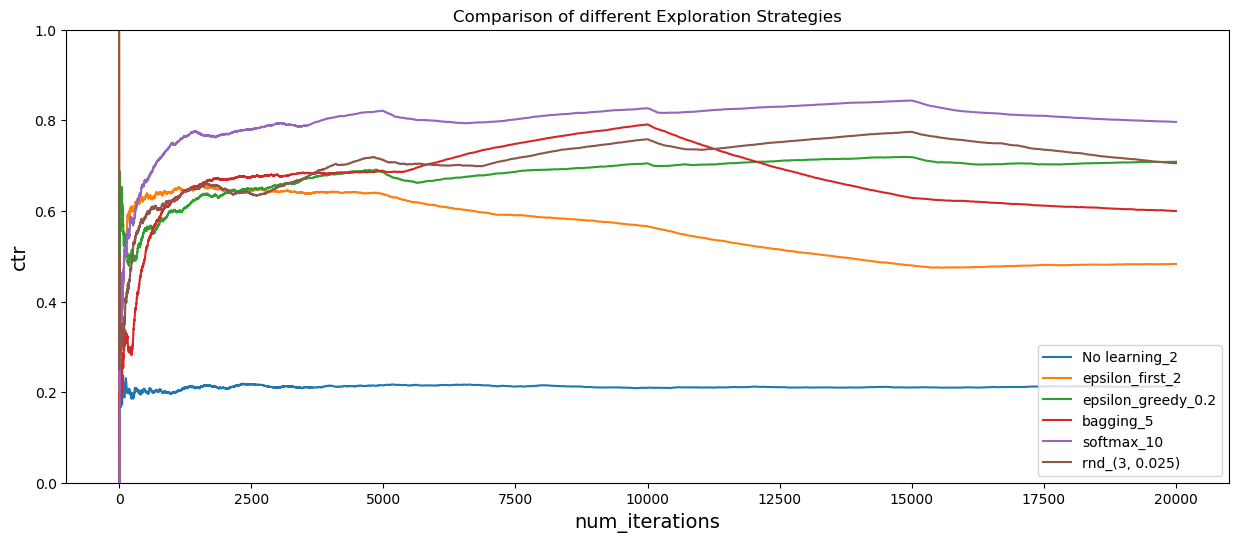

In [14]:
# Running with default values
plt.figure(figsize=(15, 6), dpi=100)
run_algorithm(None, None)
run_algorithm('epsilon_first', 2)
run_algorithm('epsilon_greedy', 0.2)
run_algorithm('bagging', 5)
run_algorithm('softmax', 10)
run_algorithm('rnd', (3, 0.025))
plt.legend(loc='lower right')
plt.title("Comparison of different Exploration Strategies")
plt.show()

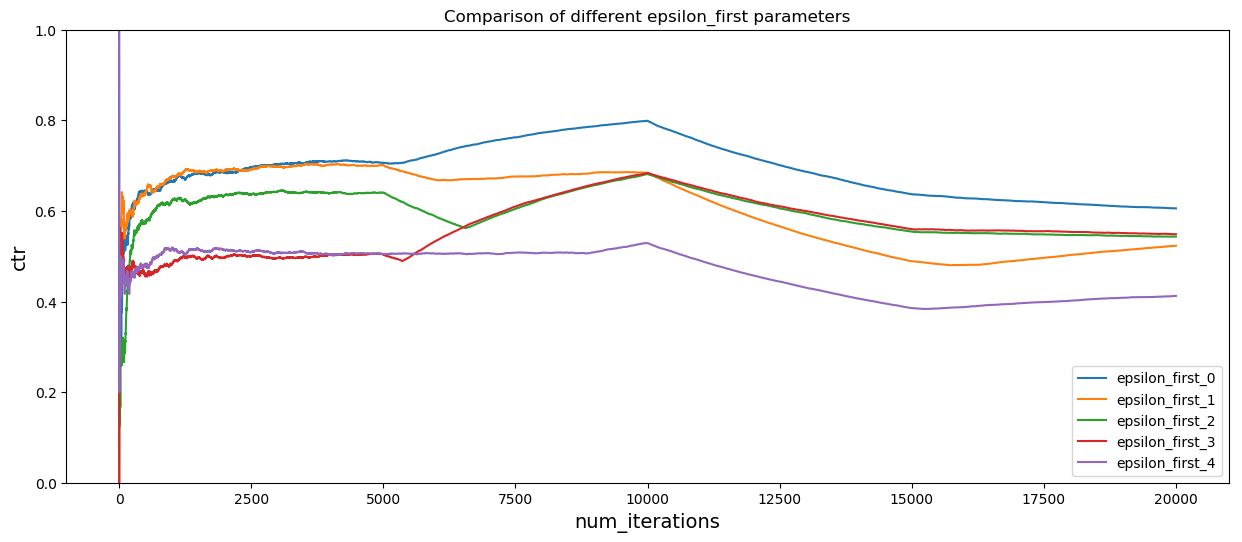

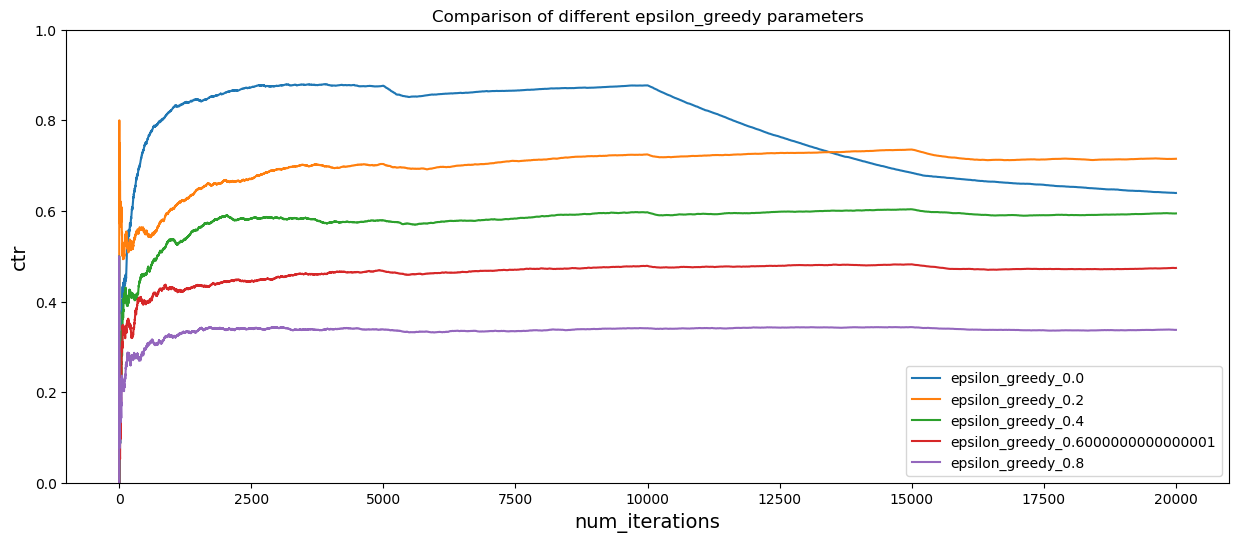

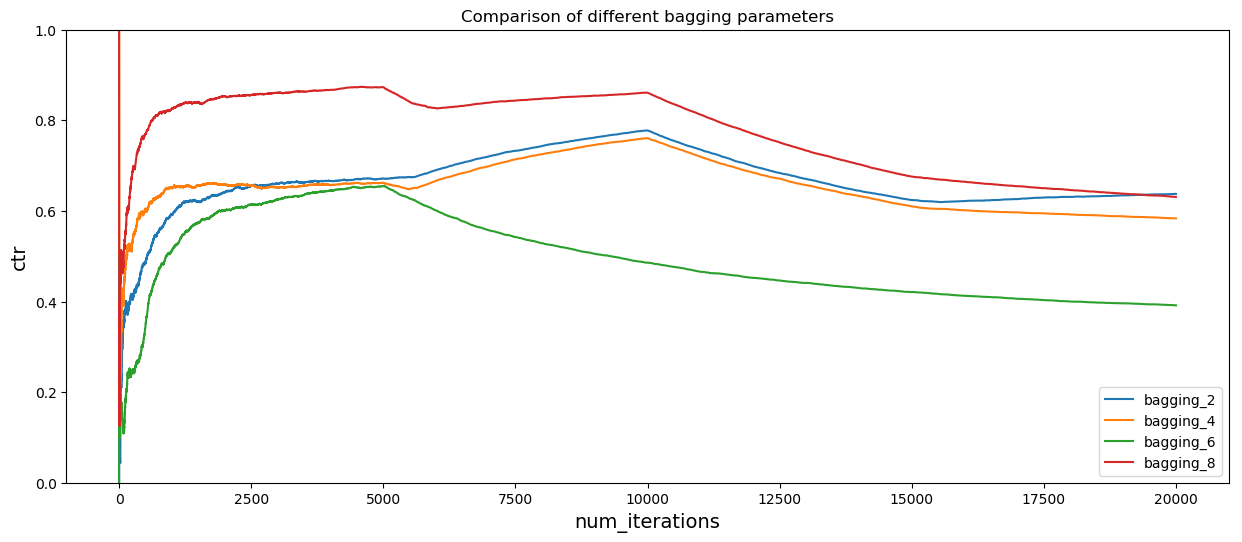

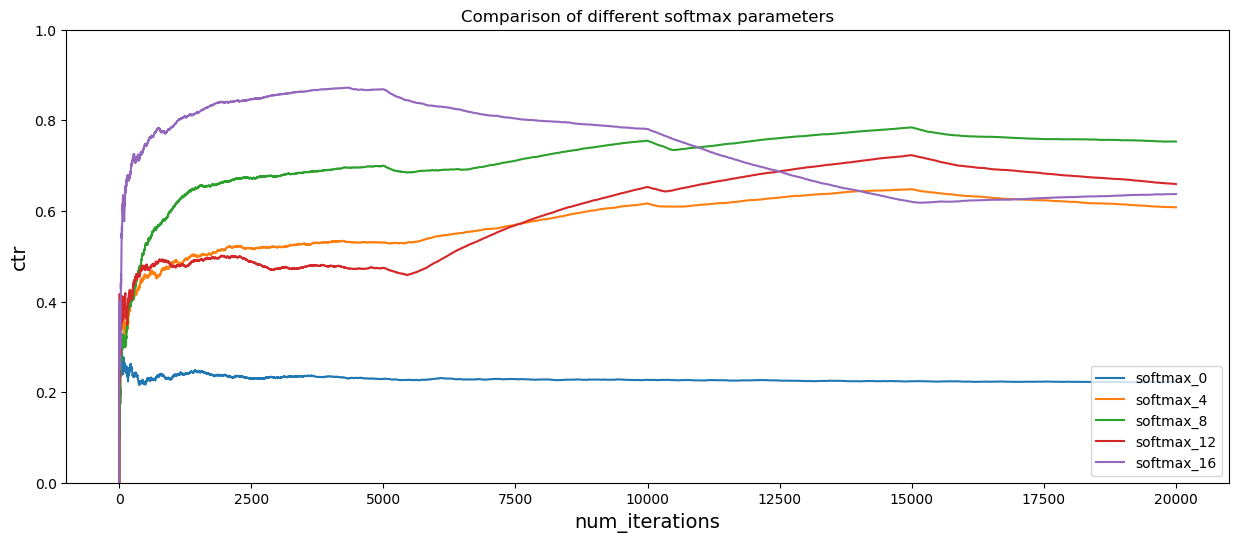

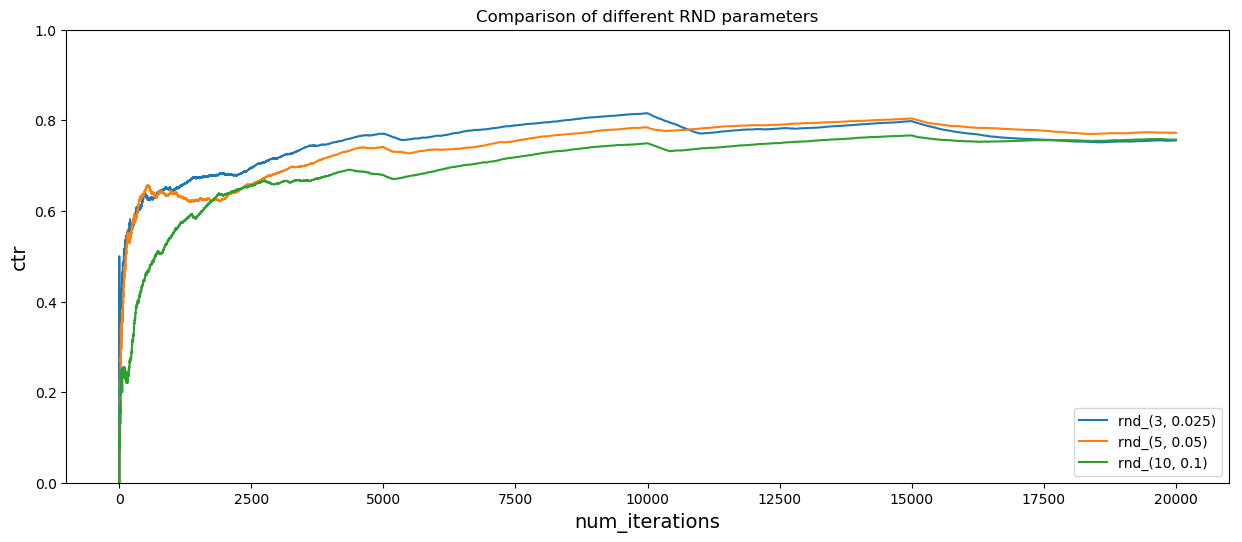

In [15]:
# Running each algo with various params
config = {
    'epsilon_first': (0, 5, 1),
    'epsilon_greedy': (0, 1, 0.2),
    'bagging': (2, 10, 2),
    'softmax': (0, 20, 4)
}
for algo in config.keys():
    plt.figure(figsize=(15, 6), dpi=100)
    for param in np.arange(*config[algo]):
        run_algorithm(algo, param)
    plt.legend(loc='lower right')
    plt.title("Comparison of different {} parameters".format(algo))
    plt.show()

# RND
plt.figure(figsize=(15, 6), dpi=100)
for param in [(3, 0.025),(5, 0.05),(10, 0.1)]:
    run_algorithm('rnd', param)
plt.legend(loc='lower right')
plt.title("Comparison of different RND parameters")
plt.show()

RND looks robust to hyperparameter changes and is resilient to changes in reward distribution. Epsilon greedy's behaviour is as expected, resilient to changes in distribution as exploration is always going on, but if exploration rate is high, exploitation reduces hence ctr gets low.  
In several cases, there's a sharp downward trend after 10000 iterations i.e, after the 3rd reward distribution kicks in. This distribution favours completely new actions, thus the decrease in ctr. Only those still exploring can increase the ctr. For example in Softmax(high lambda implies low exploration), lambda=16 falls after change in reward distribution. Similar is the case with Epsilon greedy with 0 epsilon(i.e, no exploration), and every Epsilon-first, as it explores only for first few examples.

#### Thank You!